## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],BN_before_ac = True):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if BN_before_ac:
                x = keras.layers.Dense(units=n_units, 
                                       name="hidden_layer"+str(i+1))(input_layer)
                
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(input_layer)
                x = BatchNormalization()(x)
        else:
            if BN_before_ac:
                x = keras.layers.Dense(units=n_units, 
                                       name="hidden_layer"+str(i+1))(input_layer)
                
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [7]:
results = {}
for bs in BATCH_SIZE:
    for bba in [True,False]:
        model = build_mlp(x_train.shape[1:],10,[512, 256, 128], bba)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=bs, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        key_name = 'Batch size:%s,BN_before_ac:%s'%(bs,bba)
        results[key_name]={}
        results[key_name]['train_loss']=train_loss
        results[key_name]['valid_loss']=valid_loss
        results[key_name]['train_acc']=train_acc
        results[key_name]['valid_acc']=valid_acc

W0327 16:49:02.871760 140578111104832 deprecation.py:506] From /home/dcube/.local/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 395,146
Trainable params: 394,890
Non-trainable params: 256
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 46s 911us/step - loss: 2.1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 82s 2ms/step - loss: 2.2998 - acc: 0.1493 - val_loss: 2.1275 - val_acc: 0.2062
Epoch 2/50
50000/50000 [==============================] - 81s 2ms/step - loss: 2.2328 - acc: 0.1641 - val_loss: 2.1834 - val_acc: 0.2078
Epoch 3/50
50000/50000 [==============================] - 81s 2ms/step - loss: 2.2389 - acc: 0.1584 - val_loss: 2.2533 - val_acc: 0.1535
Epoch 4/50
50000/50000 [==============================] - 82s 2ms/step - loss: 2.2326 - acc: 0.1679 - val_loss: 2.2290 - val_acc: 0.1877
Epoch 5/50
50000/50000 [==============================] - 86s 2ms/step - loss: 2.2410 - acc: 0.1603 - val_loss: 2.3200 - val_acc: 0.1944
Epoch 6/50
50000/50000 [==============================] - 82s 2ms/step - loss: 2.2339 - acc: 0.1633 - val_loss: 2.5128 - val_acc: 0.1780
Epoch 7/50
50000/50000 [==============================] - 81s 2ms/step - loss: 2.2295 - acc: 0.1671 - val_loss: 2.5650 - val_acc

50000/50000 [==============================] - 6s 119us/step - loss: 1.5615 - acc: 0.4535 - val_loss: 1.7492 - val_acc: 0.3818
Epoch 3/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.4934 - acc: 0.4760 - val_loss: 1.5099 - val_acc: 0.4610
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.4471 - acc: 0.4923 - val_loss: 1.6174 - val_acc: 0.4382
Epoch 5/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.4106 - acc: 0.5060 - val_loss: 1.6343 - val_acc: 0.4251
Epoch 6/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.3759 - acc: 0.5176 - val_loss: 1.5004 - val_acc: 0.4689
Epoch 7/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.3560 - acc: 0.5232 - val_loss: 1.4939 - val_acc: 0.4780
Epoch 8/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.3300 - acc: 0.5326 - val_loss: 1.5252 - val_acc: 0.4611
Epoch 9/50
50000/50000 [=====================

50000/50000 [==============================] - 12s 231us/step - loss: 1.8000 - acc: 0.3607 - val_loss: 1.6206 - val_acc: 0.4262
Epoch 2/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.6450 - acc: 0.4143 - val_loss: 1.7040 - val_acc: 0.3800
Epoch 3/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.5963 - acc: 0.4331 - val_loss: 1.6080 - val_acc: 0.4313
Epoch 4/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.5610 - acc: 0.4427 - val_loss: 1.5466 - val_acc: 0.4470
Epoch 5/50
50000/50000 [==============================] - 13s 258us/step - loss: 1.5449 - acc: 0.4493 - val_loss: 1.5420 - val_acc: 0.4523
Epoch 6/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.5196 - acc: 0.4592 - val_loss: 1.5659 - val_acc: 0.4439
Epoch 7/50
50000/50000 [==============================] - 11s 224us/step - loss: 1.4736 - acc: 0.4770 - val_loss: 1.4601 - val_acc: 0.4796
Epoch 8/50
50000/50000 [==============

50000/50000 [==============================] - 3s 65us/step - loss: 1.5202 - acc: 0.4672 - val_loss: 1.6170 - val_acc: 0.4247
Epoch 3/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.4437 - acc: 0.4971 - val_loss: 1.7669 - val_acc: 0.3702
Epoch 4/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.3917 - acc: 0.5135 - val_loss: 1.6033 - val_acc: 0.4347
Epoch 5/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.3482 - acc: 0.5296 - val_loss: 1.5218 - val_acc: 0.4754
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.3176 - acc: 0.5434 - val_loss: 1.5086 - val_acc: 0.4723
Epoch 7/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.2829 - acc: 0.5518 - val_loss: 1.4864 - val_acc: 0.4853
Epoch 8/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.2578 - acc: 0.5620 - val_loss: 1.5762 - val_acc: 0.4626
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 6s 129us/step - loss: 1.7234 - acc: 0.3895 - val_loss: 1.5699 - val_acc: 0.4377
Epoch 2/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.5300 - acc: 0.4556 - val_loss: 1.5611 - val_acc: 0.4420
Epoch 3/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.4567 - acc: 0.4831 - val_loss: 1.5143 - val_acc: 0.4556
Epoch 4/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.4120 - acc: 0.4984 - val_loss: 1.4897 - val_acc: 0.4672
Epoch 5/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.3958 - acc: 0.5055 - val_loss: 1.5742 - val_acc: 0.4425
Epoch 6/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.3766 - acc: 0.5112 - val_loss: 1.4872 - val_acc: 0.4714
Epoch 7/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.3265 - acc: 0.5301 - val_loss: 1.4797 - val_acc: 0.4680
Epoch 8/50
50000/50000 [=====================

50000/50000 [==============================] - 1s 26us/step - loss: 1.5941 - acc: 0.4491 - val_loss: 1.6369 - val_acc: 0.4166
Epoch 3/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.5207 - acc: 0.4749 - val_loss: 1.6155 - val_acc: 0.4217
Epoch 4/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.4678 - acc: 0.4915 - val_loss: 1.5608 - val_acc: 0.4512
Epoch 5/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.4242 - acc: 0.5083 - val_loss: 1.5507 - val_acc: 0.4489
Epoch 6/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.3861 - acc: 0.5206 - val_loss: 1.4929 - val_acc: 0.4712
Epoch 7/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.3510 - acc: 0.5345 - val_loss: 1.4794 - val_acc: 0.4782
Epoch 8/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.3216 - acc: 0.5495 - val_loss: 1.5372 - val_acc: 0.4573
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 52us/step - loss: 1.7590 - acc: 0.3909 - val_loss: 1.6459 - val_acc: 0.4222
Epoch 2/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.4887 - acc: 0.4772 - val_loss: 1.5922 - val_acc: 0.4371
Epoch 3/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3904 - acc: 0.5121 - val_loss: 1.4795 - val_acc: 0.4742
Epoch 4/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3152 - acc: 0.5365 - val_loss: 1.5783 - val_acc: 0.4474
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.2556 - acc: 0.5595 - val_loss: 1.4683 - val_acc: 0.4762
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.2127 - acc: 0.5749 - val_loss: 1.4489 - val_acc: 0.4936
Epoch 7/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1680 - acc: 0.5902 - val_loss: 1.4953 - val_acc: 0.4801
Epoch 8/50
50000/50000 [============================

Epoch 3/50
50000/50000 [==============================] - 1s 18us/step - loss: 1.5851 - acc: 0.4504 - val_loss: 1.6140 - val_acc: 0.4389
Epoch 4/50
50000/50000 [==============================] - 1s 20us/step - loss: 1.5355 - acc: 0.4694 - val_loss: 1.5628 - val_acc: 0.4577
Epoch 5/50
50000/50000 [==============================] - 1s 18us/step - loss: 1.4956 - acc: 0.4846 - val_loss: 1.5639 - val_acc: 0.4519
Epoch 6/50
50000/50000 [==============================] - 1s 18us/step - loss: 1.4632 - acc: 0.4963 - val_loss: 1.5318 - val_acc: 0.4642
Epoch 7/50
50000/50000 [==============================] - 1s 20us/step - loss: 1.4324 - acc: 0.5066 - val_loss: 1.5495 - val_acc: 0.4470
Epoch 8/50
50000/50000 [==============================] - 1s 18us/step - loss: 1.4069 - acc: 0.5177 - val_loss: 1.4867 - val_acc: 0.4827
Epoch 9/50
50000/50000 [==============================] - 1s 22us/step - loss: 1.3820 - acc: 0.5253 - val_loss: 1.4764 - val_acc: 0.4790
Epoch 10/50
50000/50000 [================

Epoch 2/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.5456 - acc: 0.4570 - val_loss: 1.6006 - val_acc: 0.4369
Epoch 3/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.4376 - acc: 0.4978 - val_loss: 1.5546 - val_acc: 0.4470
Epoch 4/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.3650 - acc: 0.5215 - val_loss: 1.5047 - val_acc: 0.4696
Epoch 5/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.3037 - acc: 0.5436 - val_loss: 1.4877 - val_acc: 0.4777
Epoch 6/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.2546 - acc: 0.5606 - val_loss: 1.4908 - val_acc: 0.4752
Epoch 7/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.2030 - acc: 0.5784 - val_loss: 1.4566 - val_acc: 0.4859
Epoch 8/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.1557 - acc: 0.5970 - val_loss: 1.4901 - val_acc: 0.4779
Epoch 9/50
50000/50000 [=================

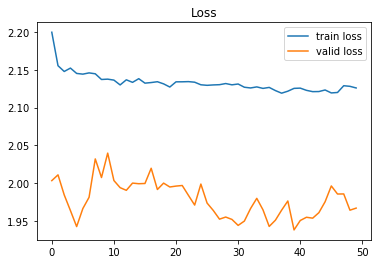

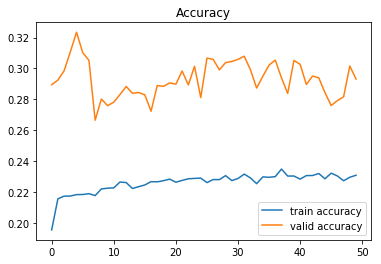

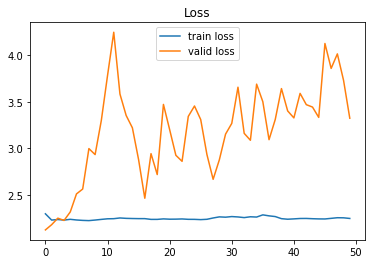

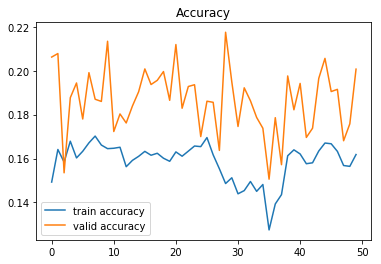

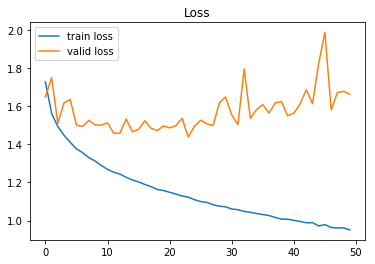

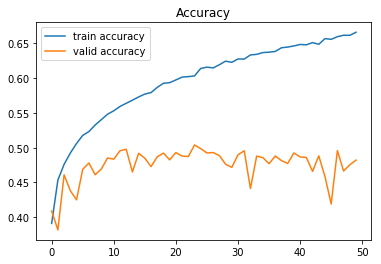

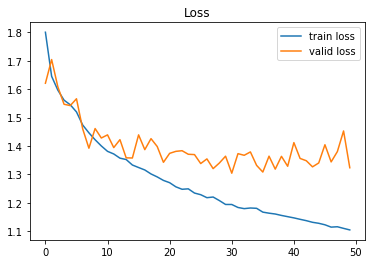

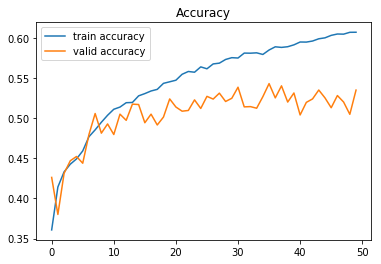

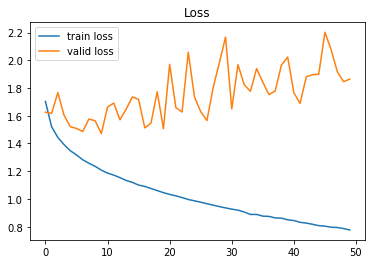

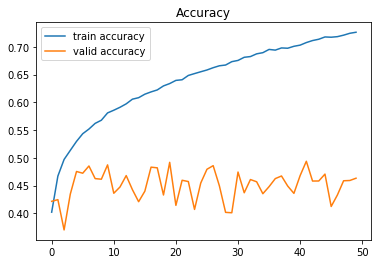

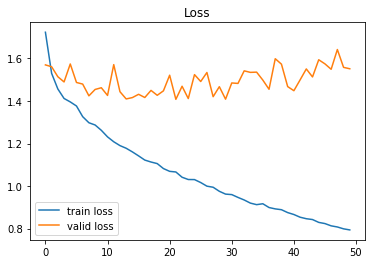

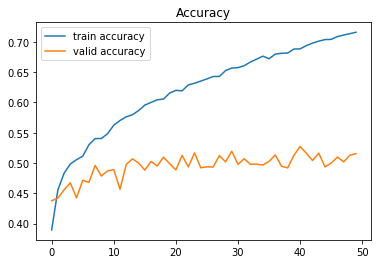

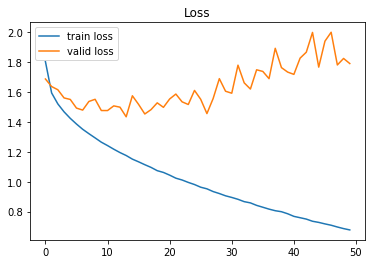

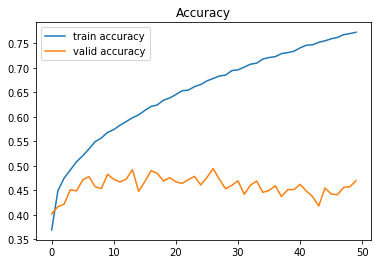

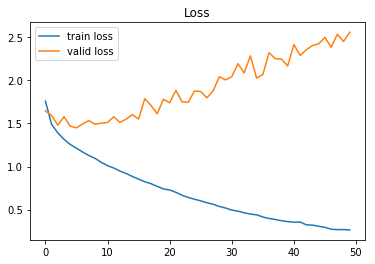

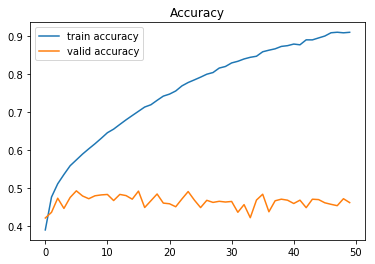

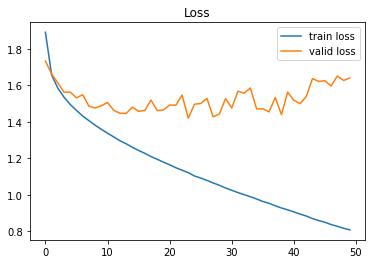

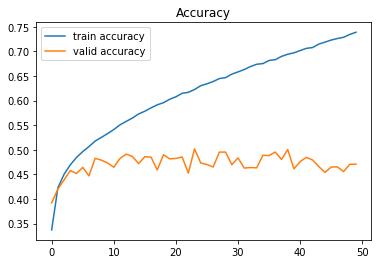

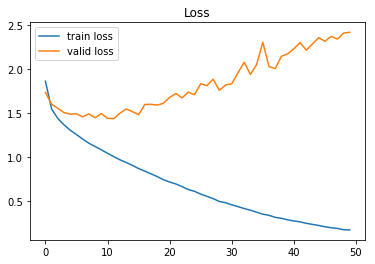

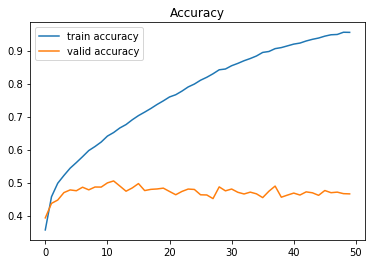

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for bs_result_dict in results:
    train_loss = results[bs_result_dict]['train_loss']
    valid_loss = results[bs_result_dict]['valid_loss']
    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    train_acc = results[bs_result_dict]['train_acc']
    valid_acc = results[bs_result_dict]['valid_acc']
    
    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()